In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

In [2]:
import numpy as np
import pandas as pd
import time
import psutil
import matplotlib.pyplot as plt 
import numpy as np

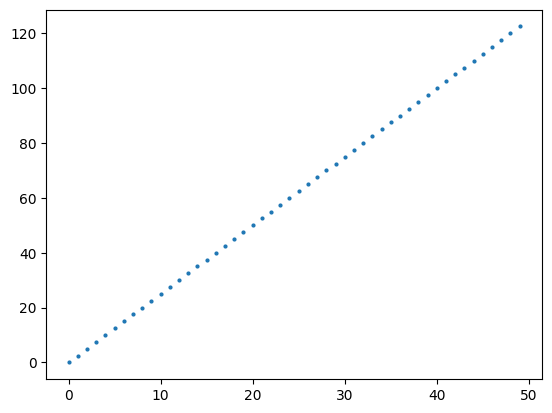

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5]


In [3]:
# Let us create some random data
# We create a very simple data set with 5 data items in it. 
size= 50

# mu, sigma = 100, 5000 # mean and standard deviation
# error=np.random.normal(mu, sigma, size)

x1 = np.arange(0, size)
# x2 = np.arange(1, size)

# y = 2.5*x1 + error
y=2.5 * x1

# y = 2*x1 + 10* x2

plt.plot(x1, y, 'o', markersize=2)
plt.show()

print(x1)
# print(x2)
# print(error)
print(y)

In [3]:
import numpy as np
from pyspark.ml.linalg import Vectors


df = np.stack([y, x1], axis=1)
print(df)

dff = map(lambda x: (float(x[0]), Vectors.dense(x[1:])), df)
mydf = spark.createDataFrame(dff, schema=["label", "features"])

print(mydf.show( truncate=False))


# Now, we create an RDD from this data. 
# X is a numpy array 
# y is a simple value lable
myRDD=mydf.rdd.map(tuple).map(lambda x: (float(x[0]), np.array(x[1]) ))

print(myRDD.take(5))

[[ 0.   0. ]
 [ 2.5  1. ]
 [ 5.   2. ]
 [ 7.5  3. ]
 [10.   4. ]]
+-----+--------+
|label|features|
+-----+--------+
|0.0  |[0.0]   |
|2.5  |[1.0]   |
|5.0  |[2.0]   |
|7.5  |[3.0]   |
|10.0 |[4.0]   |
+-----+--------+

None
[(0.0, array([0.])), (2.5, array([1.])), (5.0, array([2.])), (7.5, array([3.])), (10.0, array([4.]))]


In [4]:
# If sklearn is not installed 
# !pip3 install -q sklearn

In [5]:
from sklearn.linear_model import LinearRegression

# X = np.stack([x1, x2], axis=1)
X = np.stack([x1], axis=1)
print(X)
print(y)

reg = LinearRegression(fit_intercept=False).fit(X, y)
# reg.score(X, y)
print(reg.coef_)

[[0]
 [1]
 [2]
 [3]
 [4]]
[ 0.   2.5  5.   7.5 10. ]
[2.5]


In [6]:
# print(np.shape(X.T))
# print(np.shape(X))

# Let use solve this also with the exact linear algebra solution. 
beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(beta_hat)

[2.5]


In [7]:
# Now, we do gradient descent here with a very simple numpy array 

learningRate = 0.01
num_iteration = 30 
m_current=0

n = float(size)
# print("Sample size", n)

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    
    # Calculate the prediction with current regression coefficients. 
    y_prediction = m_current * x1 
    
    
    # We compute costs just for monitoring 
    cost= sum (( y - y_prediction)**2)

    # calculate gradients. 
    m_gradient = (-1.0/n) * sum (x1 * (y - y_prediction) )
    
    
    print(i , "m=", m_current, " Cost=", cost)
        
    # update the weights - Regression Coefficients 
    m_current = m_current - learningRate * m_gradient 

0 m= 0  Cost= 187.5
1 m= 0.15  Cost= 165.675
2 m= 0.29100000000000004  Cost= 146.39043
3 m= 0.4235400000000001  Cost= 129.350583948
4 m= 0.5481276000000002  Cost= 114.29417597645278
5 m= 0.6652399440000002  Cost= 100.99033389279367
6 m= 0.7753255473600003  Cost= 89.23505902767249
7 m= 0.8788060145184002  Cost= 78.84809815685139
8 m= 0.9760776536472963  Cost= 69.67017953139388
9 m= 1.0675129944284585  Cost= 61.56057063393965
10 m= 1.153462214762751  Cost= 54.394920212149074
11 m= 1.2342544818769858  Cost= 48.063351499454924
12 m= 1.3101992129643667  Cost= 42.46877738491837
13 m= 1.3815872601865047  Cost= 37.52541169731388
14 m= 1.4486920245753143  Cost= 33.157453775746546
15 m= 1.5117705031007955  Cost= 29.29792615624964
16 m= 1.5710642729147477  Cost= 25.887647551662187
17 m= 1.6268004165398628  Cost= 22.874325376648713
18 m= 1.6791923915474711  Cost= 20.211753902806798
19 m= 1.728440848054623  Cost= 17.859105748520083
20 m= 1.7747343971713456  Cost= 15.78030583939234
21 m= 1.818250333

In [8]:
# Now we do gradient Decent on our RDD data set. 
learningRate = 0.01
num_iteration = 30 

beta = np.zeros(1)
# print(beta)
myRDD.cache()

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    
    gradientCost=myRDD.map(lambda x: (x[1], (x[0] - x[1] * beta) ))\
                           .map(lambda x: (x[0]*x[1], x[1]**2 )).reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))
    
    cost= gradientCost[1]
    
    gradient=(-1/float(size))* gradientCost[0]
    
    print(i, "Beta", beta, " Cost", cost)
    beta = beta - learningRate * gradient
    

0 Beta [0.]  Cost [187.5]
1 Beta [0.15]  Cost [165.675]
2 Beta [0.291]  Cost [146.39043]
3 Beta [0.42354]  Cost [129.35058395]
4 Beta [0.5481276]  Cost [114.29417598]
5 Beta [0.66523994]  Cost [100.99033389]
6 Beta [0.77532555]  Cost [89.23505903]
7 Beta [0.87880601]  Cost [78.84809816]
8 Beta [0.97607765]  Cost [69.67017953]
9 Beta [1.06751299]  Cost [61.56057063]
10 Beta [1.15346221]  Cost [54.39492021]
11 Beta [1.23425448]  Cost [48.0633515]
12 Beta [1.31019921]  Cost [42.46877738]
13 Beta [1.38158726]  Cost [37.5254117]
14 Beta [1.44869202]  Cost [33.15745378]
15 Beta [1.5117705]  Cost [29.29792616]
16 Beta [1.57106427]  Cost [25.88764755]
17 Beta [1.62680042]  Cost [22.87432538]
18 Beta [1.67919239]  Cost [20.2117539]
19 Beta [1.72844085]  Cost [17.85910575]
20 Beta [1.7747344]  Cost [15.78030584]
21 Beta [1.81825033]  Cost [13.94347824]
22 Beta [1.85915531]  Cost [12.32045737]
23 Beta [1.89760599]  Cost [10.88635613]
24 Beta [1.93374963]  Cost [9.61918428]
25 Beta [1.96772466]  C